# Reconstruction of the coastal wave climate with RBF

Cases are already propagated and we now have a lot of different waves with
different characteristics propagated all along the coast so the reconstruction of the wave climate can be done.

The reconstruction of the wave climate in shallow waters is carried out by
an interpolation from the selected case series that have been propagated from
undefined depths. The interpolation technique used is based on radial basis
functions (RBF), very suitable for data with high dimensionality and not evenly
distributed. There is a series of values of the real function
$f(x_i) \:\:\: i = 1, ..., N$ in the points $x_1 , ..., x_N$. The RBF
interpolation technique considers that the RBF function approximation consists of a linear combination of symmetrical radial functions centered on the given points. The objective function has the following expression:

\begin{equation*}
RBF(x) = p(x) + \sum_{i=1}^{N}a_i\Phi\left ( \left \| x-x_i \right \| \right )
\end{equation*}

interpolating the given values as follows:

\begin{equation*}
RBF(x_i) = f_i \:\:\: i = 1 ,..., N
\end{equation*}

where $RBF$ is the interpolation function, $p(x)$ is the linear polynomial in all the
variables involved in the problem, $a_i$ are the RBF adjustment coefficients, $\Phi$ is the
basic radial function, $||\cdot||$ is the Euclidean norm and $x_i$ are the centres of
the RBF interpolation.

![RBF](../images/rbf/rbf.png)

The polynomial $p(x)$ in the expression of the RBF interpolation function is defined as a
monomial base ${p_0, p_1 ,..., p_d}$. The first is a monomial, consisting of a number of grade one monomials equal to the dimensionality of the data, where $b = {b_0 , b_1 ,..., b_d}$ are the coefficients of these monomials.

The radially based functions can have different expressions. Some of these
radial functions contain a shape parameter that plays a very important role
in the precision of the technique. In the methodology of propagation of the maritime climate, it has been considered the Gaussian radial function that depend on a shape parameter.

Notice that the RBF reconstruction is done for each CSIRO reanalysis partition, but all these partitions must be grouped together for the buoy validation and the final estimations of both the profile of the beach and the surfing regional index, which will be added to the repository in the future.

In this last paragraph, new concepts have been introduced. First, CSIRO is the name that the wave reanalysis receives and last, these two new concepts of profile analysis and surfing regional index will be added, but a detailed explanation can be seen in the attached pdf, (Javier Tausia, 2020).

In [1]:
# common 
import sys
import os
import os.path as op

# basic 
import xarray as xr
import numpy as np
import pandas as pd
from datetime import timedelta as td
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters

# warnings
import warnings
warnings.filterwarnings("ignore")

# dev library 
sys.path.insert(0, os.getcwd())

# RBF module 
from rbf_main import RBF_Reconstruction
import rbf_functions as rbff

Once the modules are imported, the preprocessing must be done, as usually. For this purpose, please just edit the selected parts, as if data is changed, it could not work. If the propagations have not been performed using the proportioned SWAN notebook, the shape of this data must match the used shape.

In [2]:
p_data = op.join(os.getcwd(), '..', 'data')
p_swan = op.join(p_data, 'projects-swan')

# -------------- EDIT THIS PART --------------------------------------------- #
name = 'CAN'               # used name in the SWAN section
resolution = str(0.0042)   # used resolution in the SWAN section (see the folder name)
num_cases = str(300)       # num cases in the SWAN section
# --------------------------------------------------------------------------- #

In [3]:
# SUBSETS
subsetsea    = pd.read_pickle(op.join(p_swan, name+'-SEA-'+resolution,
                                      'sea_cases_'+num_cases+'.pkl'))
subsetsea    = subsetsea[['hs', 'per', 'dir', 'spr']]

subsetswell  = pd.read_pickle(op.join(p_swan, name+'-SWELL-'+resolution,
                                      'swell_cases_'+num_cases+'.pkl'))
subsetswell  = subsetswell[['hs', 'per', 'dir', 'spr']]

In [4]:
# TARGETS
targetsea    = xr.open_dataset(op.join(p_swan, name+'-SEA-'+resolution,
                                       'sea_propagated_'+num_cases+'.nc'))
targetswell  = xr.open_dataset(op.join(p_swan, name+'-SWELL-'+resolution,
                                       'swell_propagated_'+num_cases+'.nc'))

In [5]:
# Reconstruction desired point

# ------- EDIT THE DESIRED POINT ------- #
# - Coordinates as shown in GoogleMaps - #
lat = 43.48
lon = -3.99
# -------------------------------------- #

# if an error occurs, please have a look at the
# resolution of the bathymetry/propagations and
# edit the reconstruction point

lat = np.where((targetsea.Y.values<lat+0.005) & 
               (targetsea.Y.values>lat-0.005))[0][0]
lon = np.where((targetswell.X.values<lon+0.005) &
               (targetswell.X.values>lon-0.005))[0][0]
targetsea   = targetsea.isel(X=lon).isel(Y=lat)
targetswell = targetswell.isel(X=lon).isel(Y=lat)
targetsea   = pd.DataFrame({'hs': targetsea.Hsig.values,
                            'per': targetsea.TPsmoo.values,
                            'perM': targetsea.Tm02.values,
                            'dir': targetsea.Dir.values,
                            'spr': targetsea.Dspr.values})
seaedit         = subsetsea.mean()
seaedit['perM'] = 7.0
targetsea       = targetsea.fillna(seaedit)
targetswell = pd.DataFrame({'hs': targetswell.Hsig.values,
                            'per': targetswell.TPsmoo.values,
                            'perM': targetswell.Tm02.values,
                            'dir': targetswell.Dir.values,
                            'spr': targetswell.Dspr.values})
swelledit         = subsetswell.mean()
swelledit['perM'] = 12.0
targetswell       = targetswell.fillna(swelledit)

In [6]:
# DATASETS
dataset_tot = pd.read_pickle(op.join(p_data, '..', 'hindcast',
                                     'csiro_dataframe_sat_corr.pkl'))
print(dataset_tot.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360840 entries, 1979-01-01 00:00:00 to 2020-02-29 23:00:00
Data columns (total 29 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Hs         360840 non-null  float32
 1   Tm_01      360839 non-null  float32
 2   Tm_02      360840 non-null  float32
 3   Tp         360839 non-null  float32
 4   DirM       360839 non-null  float32
 5   DirP       360839 non-null  float32
 6   Spr        360839 non-null  float32
 7   Nwp        360840 non-null  float32
 8   U10        360840 non-null  float32
 9   V10        360840 non-null  float32
 10  W          360840 non-null  float64
 11  DirW       360832 non-null  float64
 12  Hsea       360840 non-null  float32
 13  Hswell1    360840 non-null  float32
 14  Hswell2    360840 non-null  float32
 15  Hswell3    360840 non-null  float32
 16  Tpsea      172510 non-null  float32
 17  Tpswell1   321377 non-null  float32
 18  Tpswell2   138960 non-null  fl

In [7]:
# Choose the seas and swells to perform the reconstruction as shown:
# as mentioned in previous notebooks, please edit if more partitions exist

labels_input   = [['Hsea', 'Tpsea', 'Dirsea', 'Sprsea'],
                  ['Hswell1', 'Tpswell1','Dirswell1', 'Sprswell1'],
                  ['Hswell2', 'Tpswell2','Dirswell2', 'Sprswell2'],
                  ['Hswell3', 'Tpswell3','Dirswell3', 'Sprswell3']]
labels_output  = [['Hsea', 'Tpsea', 'Tm_02', 'Dirsea', 'Sprsea'],
                  ['Hswell1', 'Tpswell1', 'Tm_02','Dirswell1', 'Sprswell1'],
                  ['Hswell2', 'Tpswell2', 'Tm_02','Dirswell2', 'Sprswell2'],
                  ['Hswell3', 'Tpswell3', 'Tm_02','Dirswell3', 'Sprswell3']]
datasets = []

for ss in labels_input:
    dataset_ss = dataset_tot[ss]
    dataset_ss = dataset_ss.dropna(axis=0, how='any')
    datasets.append(dataset_ss)
    
dataframes = []

In [8]:
print('Performing RFB reconstruction... \n')

# RBF 
for count, dat in enumerate(datasets):
    # Scalar and directional columns
    ix_scalar_subset = [0,1,3]
    ix_directional_subset = [2]
    ix_scalar_target = [0,1,2,4]
    ix_directional_target = [3] 
    # RBF for the seas
    if count==0:
        # Calculating subset, target and dataset
        subset  = subsetsea.to_numpy()
        target  = targetsea.to_numpy()
        dat_index = dat.index
        dataset = dat.to_numpy()
        # Performing RBF
        output = RBF_Reconstruction(
                    subset, ix_scalar_subset, ix_directional_subset,
                    target, ix_scalar_target, ix_directional_target,
                    dataset
                    )
        # Reconstrucing the new dataframe
        for l, lab in enumerate(labels_output[count]):
            if l==0:
                output_dataframe = pd.DataFrame({lab: output[:,l]}, 
                                                 index=dat_index)
            else:
                output_dataframe[lab] = output[:,l]
        # Appending all new dataframes    
        dataframes.append(output_dataframe)
    # RBF for the swellls    
    else:
        # Calculating subset, target and dataset
        subset  = subsetswell.to_numpy()
        target  = targetswell.to_numpy()
        dat_index = dat.index
        dataset = dat.to_numpy()
        # Performing RBF
        output = RBF_Reconstruction(
                    subset, ix_scalar_subset, ix_directional_subset,
                    target, ix_scalar_target, ix_directional_target,
                    dataset
                    )
        # Reconstrucing the new dataframe
        for l, lab in enumerate(labels_output[count]):
            if l==0:
                output_dataframe = pd.DataFrame({lab: output[:,l]}, 
                                                 index=dat_index)
            else:
                output_dataframe[lab] = output[:,l]
        # Appending all new dataframes        
        dataframes.append(output_dataframe)

# SAVE final file
reconstructed_dataframe = pd.concat(dataframes, axis=1)

# But we first maintain just one Tm, as they are all the same
Tm_02 = reconstructed_dataframe['Tm_02'].mean(axis=1)
reconstructed_dataframe = reconstructed_dataframe.drop(columns=['Tm_02'])
reconstructed_dataframe['Tm_02'] = Tm_02

# Saving
reconstructed_dataframe.to_pickle(op.join(p_data, '..', 'reconstructed',
                                  'reconstructed_partitioned_'+name+'.pkl'))

print(reconstructed_dataframe)

Performing RFB reconstruction... 

ix_scalar: 0,  optimization: 7.21 | interpolation: 13.07
ix_scalar: 1,  optimization: 12.79 | interpolation: 12.70
ix_scalar: 2,  optimization: 5.72 | interpolation: 11.70
ix_scalar: 4,  optimization: 6.20 | interpolation: 11.59
ix_directional: 3,  optimization: 11.47 | interpolation: 23.64
ix_scalar: 0,  optimization: 6.86 | interpolation: 22.08
ix_scalar: 1,  optimization: 15.69 | interpolation: 25.46
ix_scalar: 2,  optimization: 13.49 | interpolation: 30.70
ix_scalar: 4,  optimization: 8.04 | interpolation: 22.21
ix_directional: 3,  optimization: 11.52 | interpolation: 46.13
ix_scalar: 0,  optimization: 8.89 | interpolation: 9.73
ix_scalar: 1,  optimization: 13.03 | interpolation: 10.38
ix_scalar: 2,  optimization: 13.41 | interpolation: 9.74
ix_scalar: 4,  optimization: 6.63 | interpolation: 9.21
ix_directional: 3,  optimization: 11.61 | interpolation: 19.66
ix_scalar: 0,  optimization: 6.41 | interpolation: 3.28
ix_scalar: 1,  optimization: 12.01

Once the reconstruction has been performed, we now have different partitions propagated in the selected point. These propagations can be added to obtain the requested bulk variables for both the validation with coastal buoys and the creation of the surfing index if wanted. This can be done using two different methods:

- Bulk parameters
- Spectral parameters

In this case, we will use the bulk reconstruction, as it is easier and much more important, faster, but a notebook is also added that uses the spectral reconstruction, explained in detail there.

For the bulk or aggregated conditions, the following formulas are used to calculate the significant wave height, the wave peak period and the wave mean direction:

\begin{equation*}
H_S=\sqrt{\sum_{i=1}^{N}H_{Si}^{2}}
\end{equation*}

\begin{equation*}
T_P=\sqrt{\frac{\sum_{i=1}^{N}H_{Si}}{\sum_{i=1}^{N}\frac{H_{Si}}{T_{Pi}^{2}}}}
\end{equation*}

\begin{equation*}
\theta_m=\arctan{\frac{\sum_{i=1}^{N}H_{Si}^{2} \: T_{Pi} \: \sin{\theta_i}}{\sum_{i=1}^{N}H_{Si}^{2} \: T_{Pi} \: \cos{\theta_i}}}
\end{equation*}

where using them, these aggregated parameters can be obtained, leading to a complete reconstructed dataframe in the desired point.

In [13]:
# First copy to play with NaNs
agg = reconstructed_dataframe.copy()
agg[['Tpsea', 'Tpswell1', 'Tpswell2', 'Tpswell3']] = \
    agg[['Tpsea', 'Tpswell1', 'Tpswell2', 'Tpswell3']].fillna(np.inf)
agg = agg.fillna(0.0)

# Bulk Hs
reconstructed_dataframe['Hs_Agg'] = np.sqrt(
        agg['Hsea']**2 +
        agg['Hswell1']**2 +
        agg['Hswell2']**2 +
        agg['Hswell3']**2
        )

# Bulk Tp
reconstructed_dataframe['Tp_Agg'] = np.sqrt(
        reconstructed_dataframe['Hs_Agg']**2 / (agg['Hsea']**2/agg['Tpsea']**2 + 
                          agg['Hswell1']**2/agg['Tpswell1']**2 +
                          agg['Hswell2']**2/agg['Tpswell2']**2 +
                          agg['Hswell3']**2/agg['Tpswell3']**2)
        )
        
# Second copy to play with NaNs
agg = reconstructed_dataframe.copy().fillna(0.0)

# Bulk Dir
reconstructed_dataframe['Dir_Agg'] = np.arctan(
        (agg['Hsea']*agg['Tpsea']*np.sin(agg['Dirsea']*np.pi/180) +
         agg['Hswell1']*agg['Tpswell1']*np.sin(agg['Dirswell1']*np.pi/180) +
         agg['Hswell2']*agg['Tpswell2']*np.sin(agg['Dirswell2']*np.pi/180) +
         agg['Hswell3']*agg['Tpswell3']*np.sin(agg['Dirswell3']*np.pi/180)) /
        (agg['Hsea']*agg['Tpsea']*np.cos(agg['Dirsea']*np.pi/180) +
         agg['Hswell1']*agg['Tpswell1']*np.cos(agg['Dirswell1']*np.pi/180) +
         agg['Hswell2']*agg['Tpswell2']*np.cos(agg['Dirswell2']*np.pi/180) +
         agg['Hswell3']*agg['Tpswell3']*np.cos(agg['Dirswell3']*np.pi/180))
        )
reconstructed_dataframe['Dir_Agg'] = reconstructed_dataframe['Dir_Agg']*180/np.pi
reconstructed_dataframe['Dir_Agg'] = reconstructed_dataframe['Dir_Agg'].where(reconstructed_dataframe['Dir_Agg']>0, 
                                          reconstructed_dataframe['Dir_Agg']+360)

# Wind features
reconstructed_dataframe = reconstructed_dataframe.join(dataset_tot[['W', 'DirW']])

In [11]:
# In case coastal buoy exists
print('Extracting Buoy information...')

buoy = pd.read_pickle(op.join(p_data, '..', 'buoy', 'dataframe_vir.pkl')) # this data is an example
# the buoy is located in the north of Spain
buoy.index = buoy.index.round('H')
buoy = buoy.drop_duplicates()
buoy_index = sorted(buoy.index.values)

Extracting Buoy information...


In [17]:
# In case spectral reconstruction has been performed
# REFER TO THE SPECTRA NOTEBOOK FOR MORE INFORMATION
print('Extracting spectral data...')

data_spec = pd.read_csv(op.join(p_data, '..', 'spectra', 'spectra_'+name+'.csv'))
data_spec.index = data_spec[data_spec.columns.values[0]].values
data_spec = data_spec.drop(columns=data_spec.columns.values[0])
reconstructed_dataframe = reconstructed_dataframe.join(data_spec)

Concatinating and plotting data...


In [18]:
print(reconstructed_dataframe.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 360839 entries, 1979-01-01 01:00:00 to 2020-02-29 23:00:00
Freq: H
Data columns (total 27 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Hsea       172510 non-null  float64
 1   Tpsea      172510 non-null  float64
 2   Dirsea     172510 non-null  float64
 3   Sprsea     172510 non-null  float64
 4   Hswell1    321377 non-null  float64
 5   Tpswell1   321377 non-null  float64
 6   Dirswell1  321377 non-null  float64
 7   Sprswell1  321377 non-null  float64
 8   Hswell2    138960 non-null  float64
 9   Tpswell2   138960 non-null  float64
 10  Dirswell2  138960 non-null  float64
 11  Sprswell2  138960 non-null  float64
 12  Hswell3    46833 non-null   float64
 13  Tpswell3   46833 non-null   float64
 14  Dirswell3  46833 non-null   float64
 15  Sprswell3  46833 non-null   float64
 16  Tm_02      360839 non-null  float64
 17  Hs_Agg     360839 non-null  float64
 18  Tp_Agg     360839 non-

In [19]:
reconstructed_dataframe.to_pickle(op.join(p_data, '..', 'reconstructed',
                                  'reconstructed_'+name+'.pkl'))

## RUN THIS CELL BELOW TO COMPARE THE OBTAINED RESULTS

### (Hindcast | Buoy)

--------------------------------------------------------
AGG VALIDATION will be performed
-------------------------------------------------------- 
 
Validating and plotting validated data... 
 
Length of data to validate: 13843 
 
--------------------------------------------------------
SPEC VALIDATION will be performed
-------------------------------------------------------- 
 
Validating and plotting validated data... 
 
Length of data to validate: 20 
 


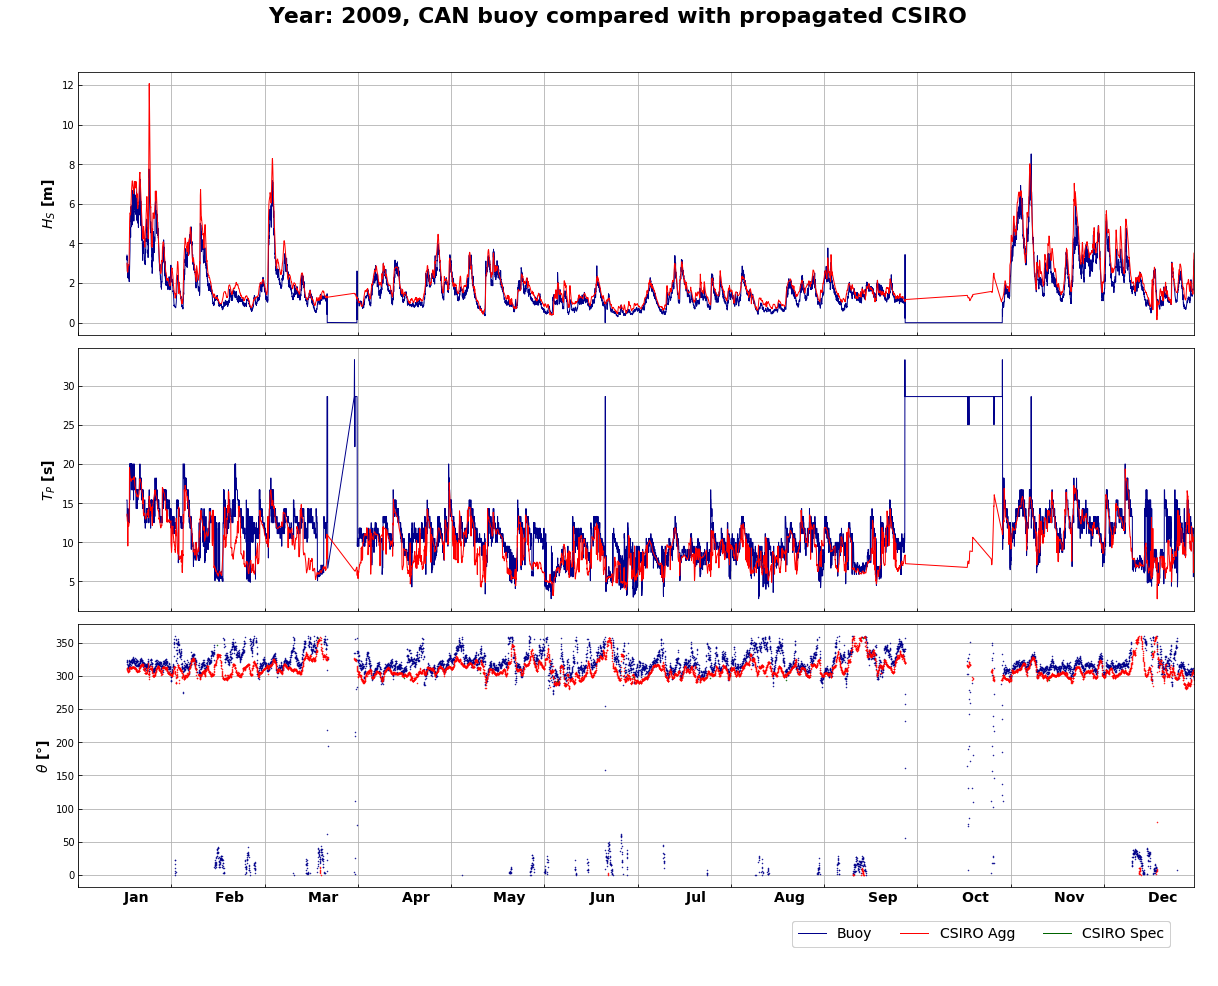

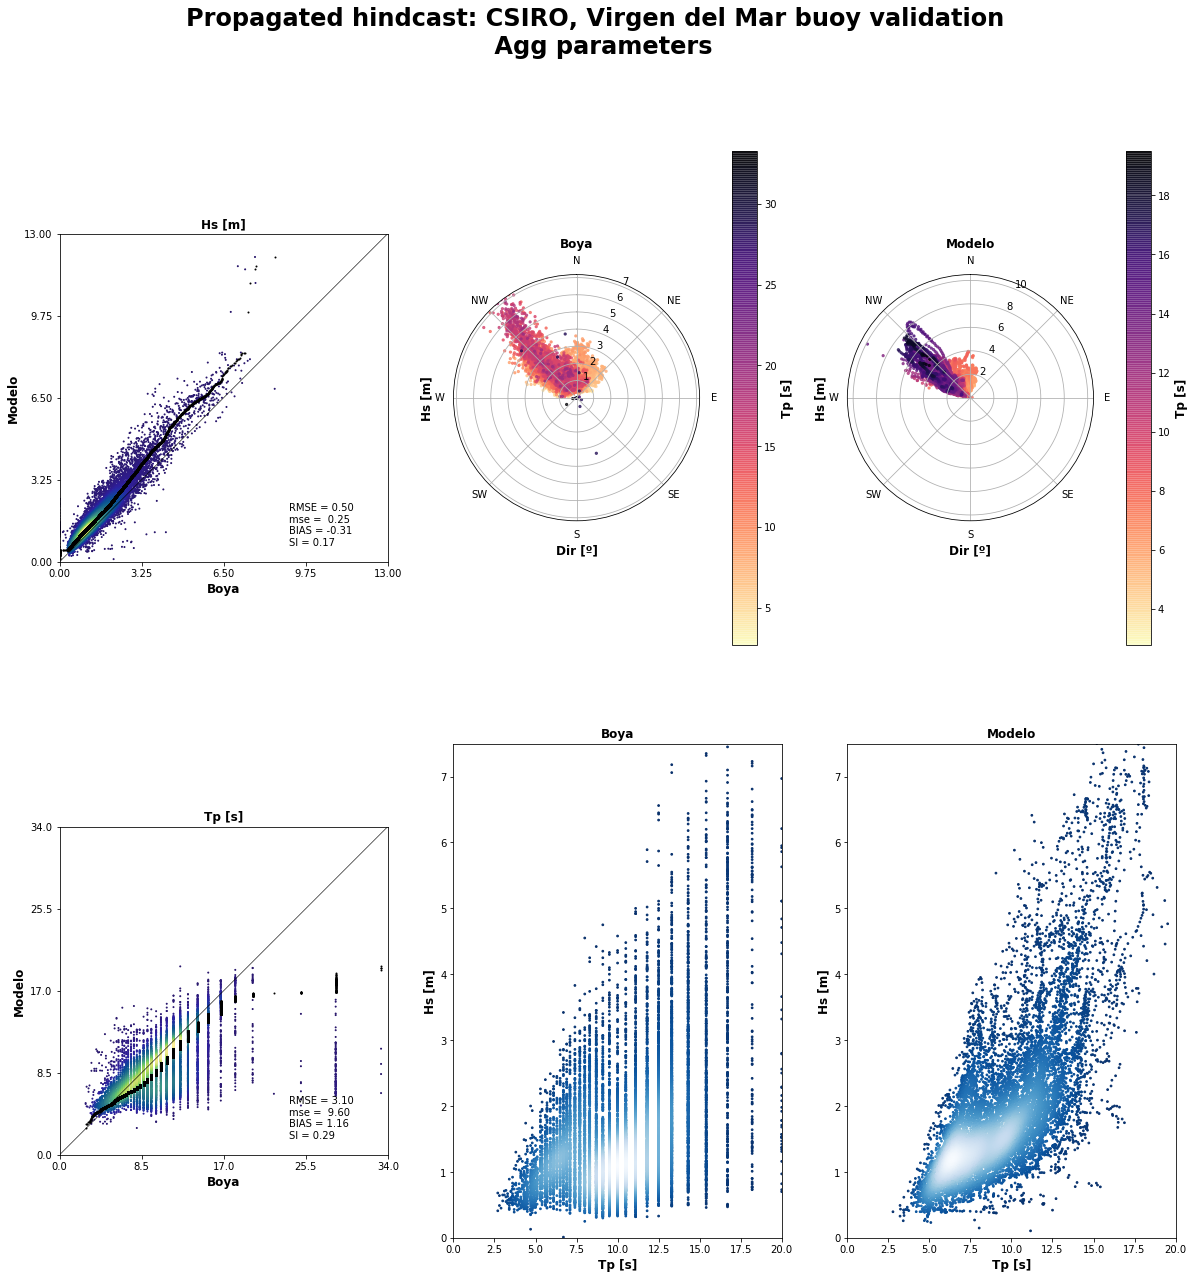

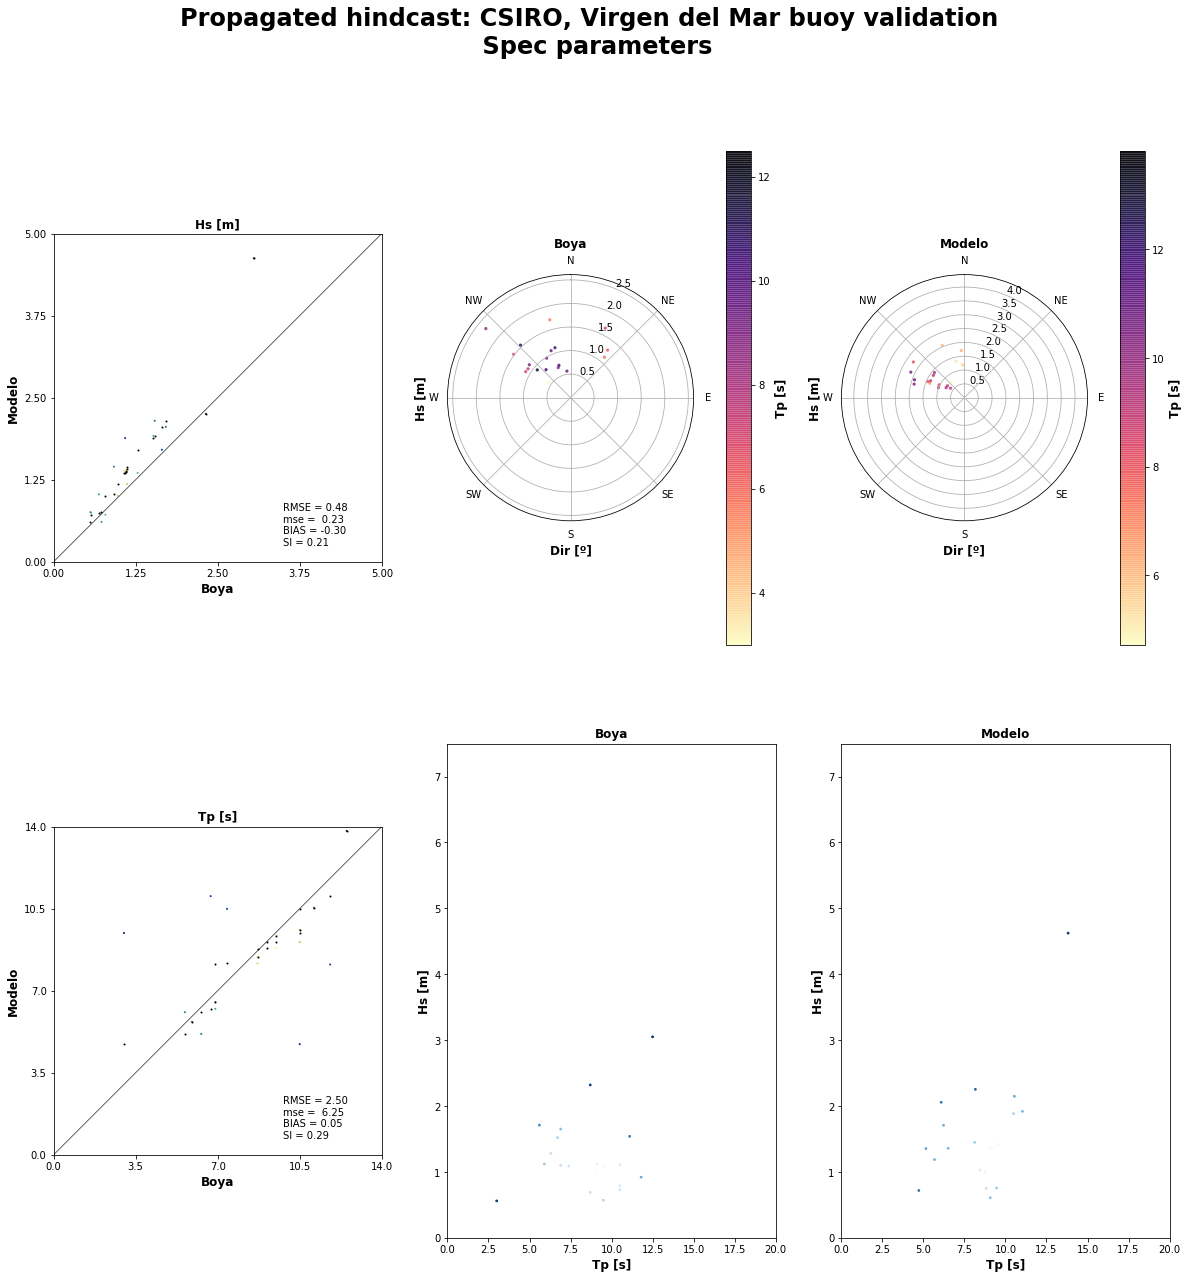

In [24]:
total = reconstructed_dataframe.join(buoy, how='inner')

total_plot = total[['Hs_Buoy', 'Tp_Buoy', 'Dir_Buoy',
                    'Hs_Agg', 'Tp_Agg', 'Dir_Agg',
                    'Hs_Spec', 'Tp_Spec', 'Dir_Spec',
                    'Hsea', 'Tpsea', 'Dirsea',
                    'Hswell1', 'Tpswell1', 'Dirswell1']]
        
labels = ['$H_S$ [m]', '$T_P$ [s]', '$\u03B8$ [$\degree$]']

validation_data = total_plot.copy()

register_matplotlib_converters()
year = 2009
ini = str(year)+'-01-01 00:00:00'
end = str(year)+'-12-31 23:00:00'
total_plot = total_plot.loc[ini:end]
fig, axs = plt.subplots(3, 1, figsize=(20,15), sharex=True)
fig.subplots_adjust(hspace=0.05, wspace=0.1)
fig.suptitle('Year: ' +str(year)+ ', ' +name+ ' buoy compared with propagated CSIRO',
             fontsize=22, y=0.94, fontweight='bold')
months = ['                        Jan', '                        Feb', '                        Mar', 
          '                        Apr', '                        May', '                        Jun', 
          '                        Jul', '                        Aug', '                        Sep', 
          '                        Oct', '                        Nov', '                        Dec']
i = 0
while i < 3:
    if i==2:
        axs[i].plot(total_plot[total_plot.columns.values[i]], '.', markersize=1, color='darkblue')
        axs[i].plot(total_plot[total_plot.columns.values[i+3]], '.', markersize=1, color='red')
        axs[i].plot(total_plot[total_plot.columns.values[i+6]], '.', markersize=1, color='darkgreen')
        #axs[i].plot(total_plot[total_plot.columns.values[i+9]], '.', markersize=1, color='orange')
        #axs[i].plot(total_plot[total_plot.columns.values[i+12]], '.', markersize=1, color='purple')
        axs[i].set_ylabel(labels[i], fontsize=14, fontweight='bold')
        axs[i].grid()
        axs[i].set_xlim(ini, end)
        axs[i].set_xticks(np.arange(pd.to_datetime(ini), pd.to_datetime(end), td(days=30.5)))
        axs[i].tick_params(direction='in')
        axs[i].set_xticklabels(months, fontsize=14, fontweight='bold')
    else:
        axs[i].plot(total_plot[total_plot.columns.values[i]], color='darkblue', linewidth=1)
        axs[i].plot(total_plot[total_plot.columns.values[i+3]], color='red', linewidth=1)
        axs[i].plot(total_plot[total_plot.columns.values[i+6]], color='darkgreen', linewidth=1)
        #axs[i].plot(total_plot[total_plot.columns.values[i+9]], color='orange', linewidth=1)
        #axs[i].plot(total_plot[total_plot.columns.values[i+12]], color='purple', linewidth=1)
        axs[i].set_ylabel(labels[i], fontsize=14, fontweight='bold')
        axs[i].grid()
        axs[i].tick_params(direction='in')
    fig.legend(['Buoy', 'CSIRO Agg', 'CSIRO Spec'], loc=(0.65, 0.04), ncol=3, fontsize=14)
    i += 1
    
rbff.buoy_validation(validation_data, 'Virgen del Mar', 'agg')
rbff.buoy_validation(validation_data, 'Virgen del Mar', 'spec')